In [1]:
import zipfile
import scipy.io
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import mne
import torch
from torchvision import datasets, transforms

In [2]:
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')

import custom_dataset

## Inspect Florida

In [3]:
df_florida = pd.read_csv('/scratch/mcesped/Datasets/segments_uflorida.csv', sep=",", index_col="index")
df_florida.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name,time_series_index
index,,,,,,,,,,,
1,Left-Hippocampus|Left-Hippocampus,2,LAH2-3,depth,UFlorida,1,1,x000001,0,pathology,403665
2,Left-Hippocampus|Left-Hippocampus,2,LAH3-4,depth,UFlorida,1,1,x000002,0,pathology,386386
3,Left-Hippocampus|Left-Hippocampus,2,LAH3-4,depth,UFlorida,1,1,x000003,0,pathology,390249
4,Left-Hippocampus|Left-Hippocampus,2,LAH3-4,depth,UFlorida,1,1,x000004,0,pathology,435349
5,Left-Hippocampus|Left-Hippocampus,2,LAH3-4,depth,UFlorida,1,1,x000005,0,pathology,443032


In [5]:
np.unique(df_florida.category_name, return_counts=True)

(array(['noise', 'pathology', 'physiology', 'powerline'], dtype=object),
 array([  22, 1374,  657,    5]))

## Merging 2 datasets

In [3]:
zip_files = ['/home/mcesped/scratch/Datasets/Dataset_Fnusa_np.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo_np.zip']
df_train, df_val = custom_dataset.get_train_val_sets(zip_files)
df_train.head()

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
0,0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline
1,1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline
2,2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline
3,3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline
4,4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline


In [4]:
df_train.tail()

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
244182,155177,NaN,2,LPD_4,depth,mayo,23,3,x155177,0,pathology
244183,155178,NaN,2,LPD_4,depth,mayo,23,3,x155178,0,pathology
244184,155179,NaN,2,LPD_4,depth,mayo,23,3,x155179,0,pathology
244185,155180,NaN,2,LPD_4,depth,mayo,23,3,x155180,0,pathology
244186,155181,NaN,2,LPD_4,depth,mayo,23,2,x155181,0,pathology


In [5]:
tmpdir = os.environ.get('SLURM_TMPDIR')

In [16]:
df_train.shape

(244187, 11)

In [17]:
df_train['institution'][0]

'fnusa'

In [6]:
import seaborn as sns

In [15]:
for category in np.unique(df_train.category_name):
    print(f'\nRegions for {category}:\n')
    print('Train\n')
    df_tmp = df_train.loc[df_train['category_name']==category]
    print(df_tmp['anatomy'].unique())
    print('\nTest\n')
    df_tmp = df_val.loc[df_val['category_name']==category]
    print(df_tmp['anatomy'].unique())


Regions for noise:

Train

['amygdala' 'gyrus temporalis medius' 'insula/gyrus temporalis superior'
 'gyrus temporalis superior' 'wm' 'hippocampus anterior' 'none'
 'ventricle' 'hippocampus posterior' 'gyrus temporalis inferior'
 'gyrus fusiformis' 'gyrus precentralis'
 'sulcus parietooccipitalis/precuneus' 'cuneus' 'precuneus'
 'gyrus angularis' 'gyrus cinguli' 'gyrus supramarginalis'
 'gyrus parahippocampalis' 'gyrus lingualis' 'insula'
 'lobulus parietalis inferior' nan 'Right-Hippocampus' 'Right-Amygdala'
 'Left-Amygdala' 'Left-Hippocampus' 'Left-Cerebral-White-Matter'
 'Right-Cerebral-White-Matter' 'ctx-rh-fusiform' 'Right-choroid-plexus'
 'ctx-rh-parahippocampal' 'Left-VentralDC' 'ctx-rh-temporalpole' 'Unknown'
 'Left-Thalamus-Proper' 'Left-Putamen' 'lingual' 'isthmuscingulate'
 'Left-Inf-Lat-Vent' 'ctx-lh-superiortemporal' 'ctx-lh-middletemporal'
 'ctx-lh-parahippocampal' 'ctx-lh-inferiortemporal' 'ctx-rh-entorhinal'
 'ctx-lh-insula' 'Right-Putamen' 'ctx-rh-inferiorparietal'
 '

## Using uncompressed data

In [3]:
# zip_files = ['/home/mcesped/scratch/Datasets/Dataset_UFlorida_np_maps.zip']
zip_files = ['/home/mcesped/scratch/Datasets/Dataset_Fnusa_np_maps.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo_np_maps.zip']
df_train, df_val = custom_dataset.get_train_val_sets(zip_files, random_split=False)
df_train.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/mcesped/scratch/Datasets/Dataset_Fnusa_np_maps.zip'

In [6]:
len(df_train)/(len(df_train)+len(df_val)), len(df_val)/(len(df_train)+len(df_val))

(0.701082400229687, 0.29891759977031296)

In [10]:
weights_subj = dict()
for inst in np.unique(df_train.institution):
    bool_mask = df_train.loc[(df_train.institution==inst).astype(bool) & (df_train.patient_id == 0).astype(bool)]
    # df_inst = df.loc[df_train.institution==inst]
    # print(f'subjects from inst {inst}')
    # print(np.unique(df_inst.patient_id))

In [8]:
for df,name in [(df_train, 'train'), (df_val,'val')]:
    print(name)
    for inst in np.unique(df.institution):
        df_inst = df.loc[df.institution==inst]
        print(f'subjects from inst {inst}')
        print(np.unique(df_inst.patient_id))

train
subjects from inst fnusa
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
subjects from inst mayo
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
val
subjects from inst fnusa
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
subjects from inst mayo
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [5]:
import utils

In [6]:
tmpdir = utils.get_tmpdir()
# Now uncompress
utils.uncompress_zip(zip_files=zip_files, out_dir=tmpdir)

In [7]:
print("\nCreating dataset classes...\n", end="\n", flush=True)
dataset_custom = custom_dataset.MultiLevelSpectrogramDir
train_data = dataset_custom(
    df=df_train, input_folder=tmpdir, transform=None
)
val_data = dataset_custom(
    df=df_val, input_folder=tmpdir, transform=None
)


Creating dataset classes...



In [8]:
# Test dataloader
import data_setup
train_dataloader, val_dataloader, class_names = data_setup.create_dataloaders_uncompress(zip_files, None, None, batch_size=32, num_workers=4, dataset_class='MultiLevelSpectrogramDir')
train_dataloader, val_dataloader, class_names 


Creating dataset classes...



(<torch.utils.data.dataloader.DataLoader at 0x2aac8a002740>,
 ['noise', 'pathology', 'physiology', 'powerline'])

In [12]:
len(df_train), len(train_dataloader)*32 # len is equal to number of batches

(1528, 1536)

In [54]:
# Check out single image size/shape
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 8, 30, 100]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [55]:
label

tensor([0, 0, 1, 1, 2, 0, 2, 3, 2, 2, 2, 3, 0, 2, 2, 3, 1, 1, 1, 2, 2, 2, 3, 2,
        3, 2, 1, 1, 2, 3, 3, 3])

torch.Size([32, 8, 30, 100]) tensor(2)
torch.Size([32, 8, 30, 100]) tensor(2)
torch.Size([32, 8, 30, 100]) tensor(2)
torch.Size([32, 8, 30, 100]) tensor(2)
torch.Size([32, 8, 30, 100]) tensor(2)
torch.Size([32, 8, 30, 100]) tensor(2)
torch.Size([32, 8, 30, 100]) tensor(2)
torch.Size([32, 8, 30, 100]) tensor(2)


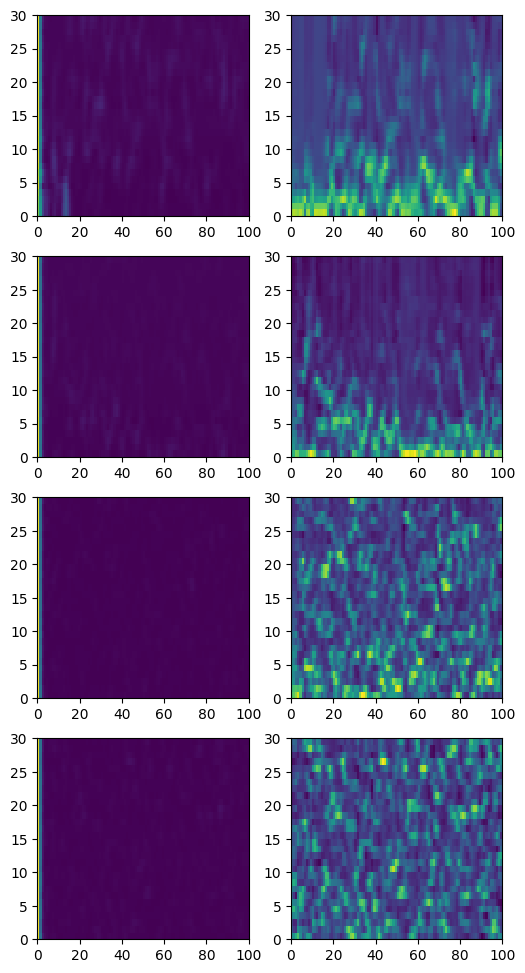

In [68]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(6,12))
n = 13
for i, ax in enumerate(axes.flat):
    # image_torch = torch.from_numpy(np.expand_dims(image, axis=0))
    # ax.pcolormesh(train_transforms(image_torch).squeeze())
    ax.pcolormesh(img[n,i,:,:])
    print(img.shape, label[n])

## Manually picked data as a whole

In [4]:
# Load two dataframes
import pandas as pd
df_mayo = pd.read_csv('/scratch/mcesped/Datasets/segments_mayo.csv', sep=",", index_col="index")
df_fnusa = pd.read_csv('/scratch/mcesped/Datasets/segments_fnusa.csv', sep=",", index_col="index")
df_total = pd.concat([df_mayo, df_fnusa])
df_total.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,NaN,1,LMacro_01,depth,mayo,0,3,x000000,1,noise
1,NaN,1,LMacro_01,depth,mayo,0,1,x000001,1,noise
2,NaN,1,LMacro_01,depth,mayo,0,3,x000002,1,noise
3,NaN,1,LMacro_01,depth,mayo,0,3,x000003,1,noise
4,NaN,1,LMacro_01,depth,mayo,0,1,x000004,1,noise


In [5]:
df_total = df_total.loc[df_total.category_id != 0]
df_total.loc[:,'category_id'] = df_total.category_id - 1

In [4]:
df_total.to_csv('/scratch/mcesped/Datasets/segments_mayo_fnusa_complete_version.csv', sep=",", index_label='index')

In [6]:
counter = {
    # 'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
categories = ['noise', 'path', 'phys']

for inst in np.unique(df_total.institution):
    df_inst = df_total.loc[df_total.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in zip(range(len(categories)), categories):
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

subjects from inst fnusa
subjects from inst mayo
{'noise': [0, 2892, 12, 8463, 5059, 0, 5416, 18, 0, 5876, 3339, 1343, 181, 2318, 0, 466, 4636, 2063, 1002, 12873, 0, 0, 740, 0, 3699, 4096, 1700, 5613, 1278, 58, 761], 'path': [1912, 1657, 8076, 0, 1527, 1554, 7738, 1896, 6750, 4260, 4072, 7710, 5318, 0, 883, 1923, 0, 0, 0, 0, 0, 2816, 0, 3426, 0, 0, 0, 0, 0, 3432, 2747], 'phys': [0, 7809, 0, 0, 5452, 962, 2689, 20860, 0, 1545, 2890, 38217, 14136, 330, 8653, 399, 2057, 790, 6583, 0, 25951, 0, 0, 498, 177, 6098, 3126, 0, 1424, 0, 644]}


In [8]:
df_evaluated = df_total
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

noise 
Number of subj: 24 
Median events per subj 2190.5 
Total events proportion 25.23208450983137 
Total events: 73902

path 
Number of subj: 18 
Median events per subj 3121.0 
Total events proportion 23.11353447893229 
Total events: 67697

phys 
Number of subj: 22 
Median events per subj 2789.5 
Total events proportion 51.65438101123634 
Total events: 151290



In [18]:
# Based on this, I'll get per class a max of 11*2000=22000 images so this means per cat per subj
max_img_subj_cat = dict()
for cat in counter:
    array_count = np.array(counter[cat])
    max_img_subj_cat[cat] = int(22000/len(array_count[array_count!=0]))
print(max_img_subj_cat)

{'pw': 2000, 'noise': 916, 'path': 1222, 'phys': 1000}


In [9]:
# Manually picked choice
max_img_subj_cat = {
    # 'pw': 1000, # Less the pw as it is easily identifiable
    'noise': 2000, # Pay more the noise
    'path': 1000, # Less path at it is not so hard to identify
    'phys': 1200
}

In [11]:
df_curated = []
for inst in np.unique(df_total.institution):
    df_inst = df_total.loc[df_total.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in zip(range(len(categories)), categories):
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa
subjects from inst mayo


In [12]:
df_curated.tail()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
73237,NaN,2,LAD_2,depth,mayo,23,1,x151633,0,physiology
73238,NaN,2,LAD_2,depth,mayo,23,1,x151602,0,physiology
73239,NaN,2,LAD_3,depth,mayo,23,1,x152095,0,physiology
73240,NaN,2,LAD_2,depth,mayo,23,1,x151440,0,physiology
73241,NaN,2,LAD_3,depth,mayo,23,1,x152058,0,physiology


In [15]:
counter = {
    # 'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
categories = ['noise', 'path', 'phys']

for inst in np.unique(df_curated.institution):
    df_inst = df_curated.loc[df_curated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in zip(range(len(categories)), categories):
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

subjects from inst fnusa
subjects from inst mayo
{'noise': [0, 2000, 12, 2000, 2000, 0, 2000, 18, 0, 2000, 2000, 1343, 181, 2000, 0, 466, 2000, 2000, 1002, 2000, 0, 0, 740, 0, 2000, 2000, 1700, 2000, 1278, 58, 761], 'path': [1000, 1000, 1000, 0, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 0, 883, 1000, 0, 0, 0, 0, 0, 1000, 0, 1000, 0, 0, 0, 0, 0, 1000, 1000], 'phys': [0, 1200, 0, 0, 1200, 962, 1200, 1200, 0, 1200, 1200, 1200, 1200, 330, 1200, 399, 1200, 790, 1200, 0, 1200, 0, 0, 498, 177, 1200, 1200, 0, 1200, 0, 644]}


In [16]:
df_evaluated = df_curated
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

noise 
Number of subj: 24 
Median events per subj 2000.0 
Total events proportion 45.81933863084023 
Total events: 33559

path 
Number of subj: 18 
Median events per subj 1000.0 
Total events proportion 24.416318505775376 
Total events: 17883

phys 
Number of subj: 22 
Median events per subj 1200.0 
Total events proportion 29.764342863384396 
Total events: 21800



In [17]:
df_train, df_test_val = custom_dataset.train_val_split_multiclass(
        df_curated, val_split=0.4, margin_allowance=0.02, class_col="institution"
    )
df_test, df_val = custom_dataset.train_val_split_multiclass(
        df_test_val, val_split=0.5, margin_allowance=0.02, class_col="institution"
    )

In [13]:
df_train.tail()

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
65831,105748,Right-VentralDC,0,LTD_1,depth,mayo,22,3,x149042,0,powerline
65832,105749,Right-VentralDC,0,LTD_1,depth,mayo,22,3,x149977,0,powerline
65833,105750,Right-VentralDC,0,LTD_1,depth,mayo,22,3,x150424,0,powerline
65834,105751,Right-VentralDC,0,LTD_1,depth,mayo,22,2,x150692,0,powerline
65835,105752,Right-VentralDC,0,LTD_1,depth,mayo,22,3,x150933,0,powerline


In [18]:
len(df_train)/len(df_curated), len(df_test_val)/len(df_curated), len(df_val)/len(df_curated), len(df_test)/len(df_curated)

(0.6152480817017558,
 0.3847519182982442,
 0.15854291253652275,
 0.22620900576172143)

In [19]:
# Subjects per dataframe
for df in [df_train, df_val, df_test]:
    for inst in np.unique(df.institution):
        df_inst = df.loc[df.institution==inst]
        print(f'subjects from inst {inst}: {np.unique(df_inst.patient_id)}')
    print('\n')

subjects from inst fnusa: [ 1  4  6  8  9 10 11 12 13]
subjects from inst mayo: [ 0  1  2  5  6  7  8  9 14 16 19 21 23]


subjects from inst fnusa: [2 3]
subjects from inst mayo: [ 3 17]


subjects from inst fnusa: [5 7]
subjects from inst mayo: [ 4 18 20]




In [34]:
# Evaluate number of subjects and events per df
counter = {
    # 'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
df_eval = df_train
for inst in np.unique(df_eval.institution):
    df_inst = df_eval.loc[df_eval.institution==inst]
    print(f'subjects from inst {inst}: {np.unique(df_inst.patient_id)}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in zip(range(len(categories)), categories):
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_eval)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa: [ 1  4  6  8  9 10 11 12 13]
subjects from inst mayo: [ 0  1  2  5  6  7  8  9 14 16 19 21 23]
noise 
Number of subj: 15 
Median events per subj 1343.0 
Total events proportion 41.207669433225334 
Total events: 18569

path 
Number of subj: 14 
Median events per subj 1000.0 
Total events proportion 30.808663619013803 
Total events: 13883

phys 
Number of subj: 14 
Median events per subj 1200.0 
Total events proportion 27.983666947760863 
Total events: 12610



In [50]:
# Save dataframe 
df_curated.to_csv('/scratch/mcesped/Datasets/segments_mayo_fnusa_curated_big_version.csv', sep=",", index_label='index')

In [4]:
df_curated = pd.read_csv('/scratch/mcesped/Datasets/segments_mayo_fnusa_curated_big_version.csv', sep=",",index_col="index")
df_curated.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,precuneus,0,R2,depth,fnusa,0,1,y005184,2,powerline
1,gyrus cinguli posterior,0,H2,depth,fnusa,0,1,y002503,0,powerline
2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000296,0,powerline
3,gyrus cinguli posterior,0,H2,depth,fnusa,0,1,y002209,0,powerline
4,gyrus cinguli posterior,0,H1,depth,fnusa,0,1,y001017,0,powerline


In [21]:
df_shorter = pd.read_csv('/scratch/mcesped/Datasets/segments_mayo_fnusa_curated_short_version.csv', sep=",",index_col="index")
df_shorter.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,gyrus cinguli posterior,0,H2,depth,fnusa,0,1,y002465,0,powerline
1,gyrus cinguli posterior,0,H3,depth,fnusa,0,1,y003394,0,powerline
2,precuneus,0,R1,depth,fnusa,0,1,y004308,2,powerline
3,precuneus,0,R2,depth,fnusa,0,1,y005918,2,powerline
4,gyrus cinguli posterior,0,H2,depth,fnusa,0,1,y002884,0,powerline


In [5]:
df.tail()

NameError: name 'df' is not defined

In [6]:
# Even shorter df from big df
# Based on this, I'll get per class a max of 11*1000=11000 images so this means per cat per subj
counter = {
    'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
for inst in np.unique(df_total.institution):
    df_inst = df_total.loc[df_total.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0,'pw'), (1, 'noise'), (2, 'path'), (3,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))

max_img_subj_cat = dict()
for cat in counter:
    array_count = np.array(counter[cat])
    max_img_subj_cat[cat] = int(11000/len(array_count[array_count!=0]))
print(max_img_subj_cat)

NameError: name 'df_total' is not defined

In [7]:
# Manually picked choice
max_img_subj_cat = {
    'pw': 500, # Less the pw as it is easily identifiable
    'noise': 1000, # Pay more the noise
    'path': 1000, # Less path at it is not so hard to identify
    'phys': 1000
}

# The automatic was
# max_img_subj_cat = {'pw': 1000, 'noise': 458, 'path': 611, 'phys': 500}


In [8]:
df_shorter = []
for inst in np.unique(df_curated.institution):
    df_inst = df_curated.loc[df_curated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0,'pw'), (1, 'noise'), (2, 'path'), (3,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_shorter)<1:
                df_shorter = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_shorter = pd.concat([df_shorter, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_shorter = df_shorter.reset_index(drop=True)

subjects from inst fnusa
subjects from inst mayo


In [9]:
df_shorter.tail()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
59607,NaN,3,LAD_1,depth,mayo,23,1,x151201,0,physiology
59608,NaN,3,LAD_3,depth,mayo,23,1,x151989,0,physiology
59609,NaN,3,LAD_3,depth,mayo,23,1,x151851,0,physiology
59610,NaN,3,LAD_1,depth,mayo,23,1,x151067,0,physiology
59611,NaN,3,LAD_3,depth,mayo,23,1,x151990,0,physiology


In [25]:
df_train, df_test_val = custom_dataset.train_val_split_multiclass(
        df_shorter, val_split=0.4, margin_allowance=0.02, class_col="institution"
    )
df_test, df_val = custom_dataset.train_val_split_multiclass(
        df_test_val, val_split=0.5, margin_allowance=0.02, class_col="institution"
    )

In [11]:
len(df_train)/len(df_shorter), len(df_test_val)/len(df_shorter), len(df_val)/len(df_shorter), len(df_test)/len(df_shorter)

(0.6093571764074347,
 0.39064282359256525,
 0.15585788096356437,
 0.23478494262900088)

In [27]:
counter = {
    'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_train
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0,'pw'), (1, 'noise'), (2, 'path'), (3,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))

for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
subjects from inst mayo
pw 
Number of subj: 6 
Median events per subj 1000.0 
Total events proportion 23.73849957443359 
Total events: 5857

noise 
Number of subj: 16 
Median events per subj 458.0 
Total events proportion 23.365622340209946 
Total events: 5765

path 
Number of subj: 11 
Median events per subj 611.0 
Total events proportion 27.24030316540348 
Total events: 6721

phys 
Number of subj: 13 
Median events per subj 500.0 
Total events proportion 25.655574919952986 
Total events: 6330



In [12]:
# Evaluate number of subjects and events per df
counter = {
    'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
df_eval = df_train
for inst in np.unique(df_eval.institution):
    df_inst = df_eval.loc[df_eval.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0,'pw'), (1, 'noise'), (2, 'path'), (3,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'Number of subj: {len(array_count[array_count!=0])}',f'Total events proportion {np.sum(array_count)*100/len(df_eval)}')

subjects from inst fnusa
subjects from inst mayo
pw Number of subj: 7 Total events proportion 9.274604267033723
noise Number of subj: 14 Total events proportion 26.722642807983483
path Number of subj: 13 Total events proportion 35.46593255333792
phys Number of subj: 13 Total events proportion 28.536820371644872


In [28]:
print(counter)

{'pw': [1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 857, 1000, 1000, 1000, 0, 0, 0, 0, 0, 1000], 'noise': [0, 0, 12, 0, 18, 0, 458, 458, 458, 181, 458, 458, 458, 458, 0, 0, 458, 0, 0, 0, 0, 458, 458, 458, 458, 58, 0], 'path': [0, 611, 611, 611, 611, 611, 611, 611, 611, 611, 0, 0, 0, 0, 0, 611, 0, 0, 0, 0, 0, 0, 0, 0, 0, 611, 0], 'phys': [0, 0, 0, 500, 500, 0, 500, 500, 500, 500, 330, 500, 500, 0, 500, 0, 0, 0, 0, 0, 0, 500, 500, 0, 500, 0, 0]}


In [82]:
# Save dataframe 
df_shorter.to_csv('/scratch/mcesped/Datasets/segments_mayo_fnusa_curated_short_version.csv', sep=",", index_label='index')

## Manually picked datasets Noise Detection

In [3]:
# Load two dataframes
import pandas as pd
df_mayo = pd.read_csv('/scratch/mcesped/Datasets/segments_mayo.csv', sep=",", index_col="index")
df_fnusa = pd.read_csv('/scratch/mcesped/Datasets/segments_fnusa.csv', sep=",", index_col="index")
df_total = pd.concat([df_mayo, df_fnusa])
df_total = df_total.loc[df_total.category_id != 0]
df_total.loc[:,'category_id'] = df_total.category_id - 1
df_total.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,NaN,0,LMacro_01,depth,mayo,0,3,x000000,1,noise
1,NaN,0,LMacro_01,depth,mayo,0,1,x000001,1,noise
2,NaN,0,LMacro_01,depth,mayo,0,3,x000002,1,noise
3,NaN,0,LMacro_01,depth,mayo,0,3,x000003,1,noise
4,NaN,0,LMacro_01,depth,mayo,0,1,x000004,1,noise


In [4]:
# Split subjects between train,val,test using subjects distribution from longer curated dataset (see above)
data_dist = {
    'fnusa': {
        'train': [ 1,  4,  6,  8,  9, 10, 11, 12, 13],
        'val': [2, 3],
        'test': [5,7]
    },
    'mayo': {
        'train': [ 0,  1,  2,  5,  6,  7,  8,  9, 14, 16, 19, 21, 23],
        'val': [ 4, 18, 20],
        'test': [3, 17] # changed val and test (respect to the automatic for more balance)

    }
}

In [5]:
categories = ['noise', 'path', 'phys']

In [6]:
# Create initial datasets
dfs = {
    'train': pd.DataFrame(columns=df_total.columns),
    'val': pd.DataFrame(columns=df_total.columns),
    'test': pd.DataFrame(columns=df_total.columns),
}


for inst in data_dist:
    df_inst = df_total.loc[df_total.institution == inst]
    for type_df in dfs:
        df_tmp = df_inst.loc[df_inst.patient_id.isin(data_dist[inst][type_df]).astype(bool)]
        # Concatenate to df
        dfs[type_df] = pd.concat([dfs[type_df], df_tmp])

### Manually adjust train set

I have seen that the performance of the model is generally better when using very few samples per subject for the training.

In [13]:
# Eval
counter = {
    # 'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = dfs['train']
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

subjects from inst fnusa
subjects from inst mayo
{'noise': [0, 8463, 0, 18, 0, 5876, 3339, 1343, 181, 2318, 0, 466, 1002, 12873, 0, 0, 740, 0, 3699, 5613, 58, 761], 'path': [1912, 0, 1554, 1896, 6750, 4260, 4072, 7710, 5318, 0, 883, 1923, 0, 0, 0, 2816, 0, 3426, 0, 0, 3432, 2747], 'phys': [0, 0, 962, 20860, 0, 1545, 2890, 38217, 14136, 330, 8653, 399, 6583, 0, 25951, 0, 0, 498, 177, 0, 0, 644]}


In [14]:
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

noise 
Number of subj: 15 
Median events per subj 1343.0 
Total events proportion 21.514629948364888 
Total events: 46750

path 
Number of subj: 14 
Median events per subj 3121.0 
Total events proportion 22.41157141936731 
Total events: 48699

phys 
Number of subj: 14 
Median events per subj 2217.5 
Total events proportion 56.0737986322678 
Total events: 121845



In [15]:
# Manually picked choice. A bit based in the whole dataset dist
max_img_subj_cat = {
    # 'pw': 500, # Less the pw as it is easily identifiable
    'noise': 2000, # Pay more the noise
    'path': 700, # Less path at it is not so hard to identify
    'phys': 1400
}

In [16]:
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa
subjects from inst mayo


In [17]:
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))

for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
subjects from inst mayo
noise 
Number of subj: 15 
Median events per subj 1343.0 
Total events proportion 43.61070011038305 
Total events: 18569

path 
Number of subj: 14 
Median events per subj 700.0 
Total events proportion 23.016040771272223 
Total events: 9800

phys 
Number of subj: 14 
Median events per subj 1400.0 
Total events proportion 33.37325911834473 
Total events: 14210



In [18]:
df_curated_train = df_curated
len(df_curated_train)

42579

### Manually adjust val set

For the validation, I'll just balance classes. Not cutting off as in training

In [23]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = dfs['val']
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

subjects from inst fnusa
subjects from inst mayo
{'noise': [2892, 12, 2063, 1700, 1278], 'path': [1657, 8076, 0, 0, 0], 'phys': [7809, 0, 790, 3126, 1424]}


In [20]:
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

noise 
Number of subj: 5 
Median events per subj 1700.0 
Total events proportion 25.7728614526227 
Total events: 7945

path 
Number of subj: 2 
Median events per subj 4866.5 
Total events proportion 31.572971745547733 
Total events: 9733

phys 
Number of subj: 4 
Median events per subj 2275.0 
Total events proportion 42.65416680182957 
Total events: 13149



In [24]:
# Manually picked choice
max_img_subj_cat = {
    # 'pw': 1500, # Less the pw as it is easily identifiable
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1200
}

df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in zip(range(len(categories)), categories):
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa
subjects from inst mayo


In [25]:
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in zip(range(len(categories)), categories):
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))

for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
subjects from inst mayo
noise 
Number of subj: 5 
Median events per subj 1700.0 
Total events proportion 48.60917941585535 
Total events: 6990

path 
Number of subj: 2 
Median events per subj 1500.0 
Total events proportion 20.86230876216968 
Total events: 3000

phys 
Number of subj: 4 
Median events per subj 1200.0 
Total events proportion 30.528511821974966 
Total events: 4390



In [26]:
df_curated_val = df_curated
len(df_curated_val)

14380

### Manually curated test set

In [27]:
# Eval
counter = {
    # 'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = dfs['test']
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in zip(range(len(categories)), categories):
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

subjects from inst fnusa
subjects from inst mayo
{'noise': [5059, 5416, 4636, 4096], 'path': [1527, 7738, 0, 0], 'phys': [5452, 2689, 2057, 6098]}


In [28]:
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

noise 
Number of subj: 4 
Median events per subj 4847.5 
Total events proportion 42.90341315225161 
Total events: 19207

path 
Number of subj: 2 
Median events per subj 4632.5 
Total events proportion 20.69558613295211 
Total events: 9265

phys 
Number of subj: 4 
Median events per subj 4070.5 
Total events proportion 36.40100071479628 
Total events: 16296



In [29]:
# Manually picked choice
max_img_subj_cat = {
    # 'pw': 500, # Less the pw as it is easily identifiable
    'noise': 2000, # Pay more the noise
    'path': 1000, # Less path at it is not so hard to identify
    'phys': 1000
}
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in zip(range(len(categories)), categories):
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa
subjects from inst mayo


In [30]:
counter = {
    # 'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in zip(range(len(categories)), categories):
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))

for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
subjects from inst mayo
noise 
Number of subj: 4 
Median events per subj 2000.0 
Total events proportion 57.142857142857146 
Total events: 8000

path 
Number of subj: 2 
Median events per subj 1000.0 
Total events proportion 14.285714285714286 
Total events: 2000

phys 
Number of subj: 4 
Median events per subj 1000.0 
Total events proportion 28.571428571428573 
Total events: 4000



In [31]:
df_curated_test = df_curated
len(df_curated_test)

14000

### Check final distribution

In [32]:
len_total = len(df_curated_train) + len(df_curated_val) + len(df_curated_test)
len(df_curated_train)*100/len_total, len(df_curated_val)*100/len_total, len(df_curated_test)*100/len_total

(60.00507335221748, 20.265223579813696, 19.729703067968828)

In [33]:
len_total = len(df_curated_train) + len(df_curated_val) 
len(df_curated_train)*100/len_total, len(df_curated_val)*100/len_total

(74.75377025579803, 25.24622974420197)

In [34]:
df_curated_train.to_csv('/scratch/mcesped/Datasets/df_train_curated.csv', sep=",", index_label='index')

In [35]:
# Ended up having a distribution of 70, 15, 15
# Save dataframes
df_curated_val.to_csv('/scratch/mcesped/Datasets/df_val_curated.csv', sep=",", index_label='index')

In [36]:
dfs['test'].to_csv('/scratch/mcesped/Datasets/df_test_curated.csv', sep=",", index_label='index')